# 概要
『Web最適化ではじめる機械学習』の第一章に当たる部分のまとめ

# 目次
- ベイズアップデート
 - 一様分布
 - サンプル追加による信念の向上
- 二項分布
 - ベルヌーイ試行
- ベータ分布
 - 共役事前分布
 - ここまでのまとめ
- 要約統計量で判断を下す
 - HDI

In [1]:
import numpy as np

デザインのA/Bテストをベイズアップデートによって判定する  
ベイズの定理  
$$
p(θ|r) =  \frac{p(r|θ) p(θ)}{p(r)}
$$
θ: デザイン固有のCTR  
r: 実際のクリック  

p(θ|r)が事後確率。クリックrによりデザイン固有のCTRを推定したい。  
p(r|θ)が尤度関数。クリックrは成功確率θのベルヌーイ試行によって生成される。つまり、クリックが得られる確率はθ、そうでない確率は1-θ。  
p(θ)が事前確率。デザイン固有のCTRに対する信念。  
p(r)が正規化定数。後ほど解説するが、直接求める必要はなく、分子（離散値）の合計値は（積分による）面積とみなせる。

また、「p(x)はパラメータxの確率分布」と基本的には捉えてよい。ただし、確率の和は必ず1になるということを踏まえ、和が1にならない場合は確率分布とみなさない。ここでは、p(θ|r)とp(θ)は確率分布、p(r|θ)とp(r)は確率分布ではない。

In [2]:
# まず、推定したいクリック率の範囲を定義しよう。
# クリック率θ, 0≦θ≦1
# 連続値の確率密度関数はコンピュータでは扱えないため、離散値の確率質量関数に近似する。
thetas = np.linspace(0, 1, 1001)
print(thetas)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]


In [3]:
# 事前分布p(θ)は一様分布に従うと仮定し生成
p = np.array([1 / len(thetas) for _ in thetas])
print(p)

[0.000999 0.000999 0.000999 ... 0.000999 0.000999 0.000999]


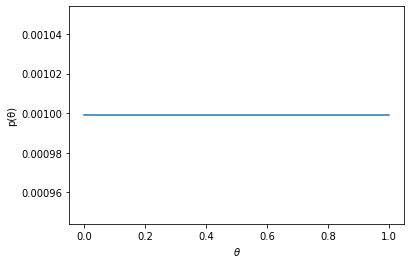

In [4]:
# 事前分布を可視化してみる。
# クリック率θが0をとる確率は0.001,クリック率θが1をとる確率は0.001と一様な確率分布が得られたことを確認できる。 
from matplotlib import pyplot as plt
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.show()

In [5]:
# 尤度　実際のクリックr=1のときthetas, r=0のとき(1 - thetas)を返す。
# この時、パラメータθをもつベルヌーイ分布を想定している。
# 要するに、r=1ならクリック率θは1だし、r=0ならクリック率θは0、ということ。
likelihood = lambda r: thetas if r else (1 - thetas)

In [6]:
# 事後分布の計算式
def posterior(r, prior):
    lp = likelihood(r) * prior
    return lp / lp.sum()

# lp = likelihood(r) * priorとは、つまり、rに対する信念（事前分布）に従うr=xが得られたとき、その尤もらしさを計算している。
# ただし、lpの面積は1になるとは限らず、そのため確率分布とは言えない（確率分布なら確率の和は必ず1）。
# だから、return文の行では、面積で割ることで1になるよう正規化するのである。
# また、面積で割ればp(r)が得られることは、確率の加法定理と乗法定理により証明できる。
# 乗法定理：Xが起きて、Yが起きる、同時確率を求めること。
# 加法定理：Xに関する確率を足し合わせると、Yに関する確率p(Y)が得られるということ。

In [7]:
# クリックが1つ与えられたとして事後分布を計算する
p = posterior(1, p)
print(p)
#数字だけ見てもよーわからんので次のセルで可視化する。

[0.00000000e+00 1.99800200e-06 3.99600400e-06 ... 1.99400599e-03
 1.99600400e-03 1.99800200e-03]


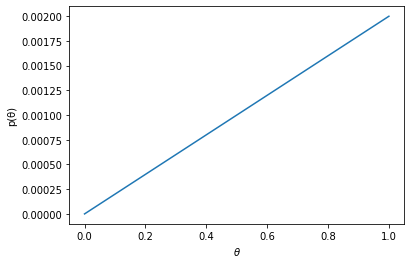

In [8]:
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.show()

もともと（ほぼ）0.001の一様分布だった事前分布が、ベイズアップデートにより右肩上がりのthetasで最大は0.002に更新された。  
定性的に言えば、クリックが起きたのだがら、より高いCTRが得られる確率が高くなるような確率分布に変化するのは当然である。

## デザインAの結果  

In [9]:
clicks = 2
noclicks = 38

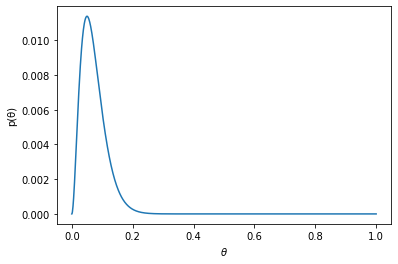

In [10]:
# ベイズアップデートを実行する。
# 単純に試行回数分（今回だとclicks + noclicks = 40）、ベイズの定理式であるposterior（）を処理すればよい。
p = np.array([1 / len(thetas) for theta in thetas])
for _ in range(clicks):
    p = posterior(1, p)
for _ in range(noclicks):
    p = posterior(0, p)
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.show()

デザインAのクリック率θは0.05の周辺にあると考えるのが妥当だという信念が得られた。

## デザインBの結果

In [11]:
clicks = 4
noclicks = 46

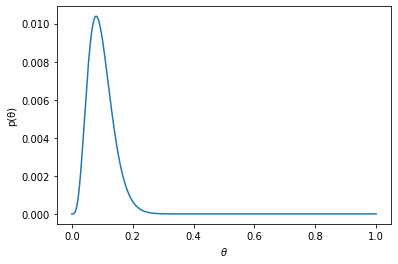

In [12]:
# ベイズアップデートを実行する。
# 単純に試行回数分（今回だとclicks + noclicks = 40）、ベイズの定理式であるposterior（）を処理すればよい。
p = np.array([1 / len(thetas) for theta in thetas])
for _ in range(clicks):
    p = posterior(1, p)
for _ in range(noclicks):
    p = posterior(0, p)
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.show()

デザインBのクリック率θは0.08の周辺にあると考えるのが妥当だという信念が得られた。

## デザインA（サンプル増加）

In [13]:
clicks = 64
noclicks = 1216

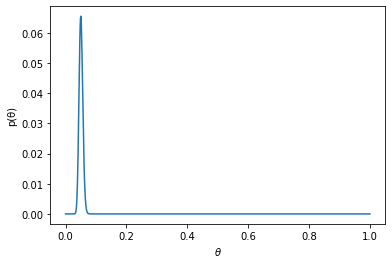

In [14]:
# ベイズアップデートを実行する。
# 単純に試行回数分（今回だとclicks + noclicks = 40）、ベイズの定理式であるposterior（）を処理すればよい。
p = np.array([1 / len(thetas) for theta in thetas])
for _ in range(clicks):
    p = posterior(1, p)
for _ in range(noclicks):
    p = posterior(0, p)
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.show()

サンプルを増やすと、0.05だという信念p(θ)がより大きくなり、裾も狭くなったことがわかる。

## デザインB（サンプル増加）

In [15]:
clicks = 128
noclicks = 1472

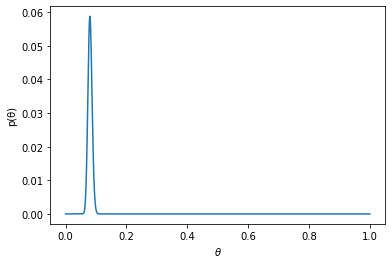

In [16]:
# ベイズアップデートを実行する。
# 単純に試行回数分（今回だとclicks + noclicks = 40）、ベイズの定理式であるposterior（）を処理すればよい。
p = np.array([1 / len(thetas) for theta in thetas])
for _ in range(clicks):
    p = posterior(1, p)
for _ in range(noclicks):
    p = posterior(0, p)
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.show()

サンプルを増やすと、0.08だという信念p(θ)がより大きくなり、裾も狭くなったことがわかる。

# 二項分布

成功確率θのベルヌーイ試行をN回行ったときの成功回数aが従う確率分布
$$
p(a|θ,N) = {}_N \mathrm{ C }_aθ^{ a }(1-θ)^{ N-a } = Binomial(θ,N)
$$
コインがθの確率で出るスロットをN回回した時に実際にa回コインを得る、という事象を想像すると良い。  

また、二項分布はベルヌーイ分布の自然な拡張なので、  
これを使うことで、上記のようにfor文でベイズアップデートを回さなくても、1回の試行でベイズアップデートができるようになる。

In [17]:
# 尤度関数について、ベルヌーイ分布を表す関数を、二項分布に置き換える。
likelihood = lambda a, N: thetas ** a * (1 - thetas) ** (N - a)

In [18]:
# 事後分布の計算式を修正する
def posterior(a, N, prior):
    lp = likelihood(a, N) * prior
    return lp / lp.sum()

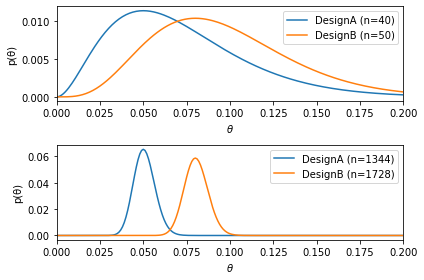

In [19]:
# 事前分布はこれまで同様一様分布から始めよう。
prior = 1 / len(thetas)

# デザインA/BのCTRであるθの事後分布を推論
plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40, prior), label='DesignA (n=40)')
plt.plot(thetas, posterior(4, 50, prior), label='DesignB (n=50)')
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.xlim(0, 0.2)
plt.legend()

# デザインA/BのCTRであるθの事後分布を推論（サンプル追加）
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280, prior), label='DesignA (n=1344)')
plt.plot(thetas, posterior(128, 1600, prior), label='DesignB (n=1728)')
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.xlim(0, 0.2)
plt.legend()

plt.tight_layout()
plt.show()

上記と同じ結果が得られたことがわかる。
- デザインBの方がCTRを表すθが高そう。
- サンプルを増やせば、裾が短くなり、信念がより高まる。

# ベータ分布

ここでα＝（N回のベルヌーイ試行における）クリック回数、β=N回とし、新しい分布を導入しよう。  
α > 0とβ > 0の2つのパラメータを持つ、0以上1以下の連続値の確率変数θ（横軸）についての確率分布。  
$$
p(θ|α,β) = Beta(α,β) = \frac{θ^{ α-1}(1-θ)^{β-1}}{\int_0^1 θ^{ α-1}(1-θ)^{β-1}dθ}
$$
特にα = 1, β = 1のとき、p(θ|α,β) = 1となり、一様分布と一致する。  
そのため、事前分布も一様分布ではなくベータ分布で拡張できる。

In [20]:
# 事前分布としてベータ関数を実装
# 上述の通り、連続値の確率密度関数はコンピュータでは扱えないので、離散確率分布への近似として、積分計算ではなく総和計算による正規化を導入
def betaf(alpha, beta):
    numerator = thetas ** (alpha - 1) * (1 - thetas) ** (beta - 1)
    return numerator / numerator.sum()

事後分布もベータ関数を用いた式に修正していくのだが、ここで共役事前分布という概念を導入する。  
今回の例では、ベイズアップデートを繰り返しても、信念を表す確率分布はベータ分布で表されるが、一般には事前分布と事後分布が同じ種類の確率分布で表されるとは限らない。  
ある尤度関数（ここではベルヌーイ分布や二項分布として出現）について、事後分布も事前分布と同じ種類の確率分布で現れる特徴を持つ事前分布のこと。  
ベイズの定理（事後分布p(θ∣x) ∝ 尤度関数p(x∣θ) × 事前分布p(θ)）に従って、式で表すとこんな感じになるやつを共役事前分布という。  
- ベータ分布 = 二項分布 × ベータ分布  

他の共役事前分布の例としては、  
- 正規分布 = 正規分布 × 正規分布  
- 逆ガンマ分布 = 正規分布 × 逆ガンマ分布  

がある。

ここで問題に戻ろう。  
CTRであるθのもとN回試行して実際のクリックr=1がa回が得られる様子は二項分布${}_N \mathrm{ C }_aθ^{ a }(1-θ)^{ N-a } $として表せた。  
これはベータ分布の分子$θ^{ α-1}(1-θ)^{β-1}$と同じ形式であり（定数項は無視）、α＝a+1, β=N-a+1が得られる。  
「このαとβを用いたベータ分布」と「もとのαとβのベータ分布」がそれぞれ事後分布、事前分布に対応するというわけである。  
前者は二項分布という尤度関数を通して得られた表現だから事後分布の式と合致するのである。

（ちなみに分母も同様に考えることができる。以下、考え方）  
先ほどの二項分布を事後分布を得るために正規化すると次のようになる。（加法定理より分母はp(a,N)である）
$$
p(θ|a,N) = \frac{θ^{ a }(1-θ)^{ N-a }}{\int_0^1 θ^{ a }(1-θ)^{ N-a }dθ}
$$
とベータ分布の式を見比べると、分母もα＝a+1, β=N-a+1で置換できるのが分かる。

In [21]:
# 事後分布の修正
# 共役事前分布の性質により、事後分布もベータ関数で表現されるようになり、シンプルになった。
def posterior(a, N):
    return betaf(a+1, N-a+1)

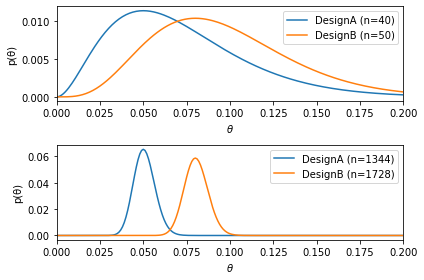

In [22]:
# デザインA/BのCTRであるθの事後分布を推論
plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40), label='DesignA (n=40)')
plt.plot(thetas, posterior(4, 50), label='DesignB (n=50)')
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.xlim(0, 0.2)
plt.legend()

# デザインA/BのCTRであるθの事後分布を推論（サンプル追加）
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280), label='DesignA (n=1344)')
plt.plot(thetas, posterior(128, 1600), label='DesignB (n=1728)')
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.xlim(0, 0.2)
plt.legend()

plt.tight_layout()
plt.show()

上記と同じ結果が得られたことがわかる。
- デザインBの方がCTRを表すθが高そう。
- サンプルを増やせば、裾が短くなり、信念がより高まる。

# まとめ
ここまででベイズアップデートの変遷をまとめる。
- 最初はシンプルにベイズの定理に則ってfor文でベイズアップデートを実装した。  
事後分布 $\propto$ 尤度関数 × 事前分布
 - 事前分布：一様分布と仮定。分析者のデザインAとBに対するクリック率θの信念。
 - 尤度関数：クリック率θに基づいて実際のクリックrが1か0で得られる、ベルヌーイ分布に従う。
- 事前分布と尤度関数をより拡張可能な形式に更新。
 - 事前分布：ベータ分布
 - 尤度関数：二項分布  

これらは共役事前分布なため、事後分布は事前分布と同じベータ分布に従うという形式でシンプルに記述できるようになった。

# 要約統計量を用いて事後分布から判断を下す
**HDI**（Highest density interval）：連続確率分布に対して定義される値で、あらゆる確率変数の値を確立密度が大きいものから順に、ある確立に至るまでカバーしたもの。例えば確率0.95を占めるまで確率密度が高いものから埋めていった区域は95%HDIと呼ばれる。

In [23]:
# HDIは連続値に対して定義されるが、ここでは確率質量に対して考えることにし、
# 確率質量ランキング上位の値の列を返すメソッドhmv（highest mass values）を実装する
def hmv(xs, ps, alpha=0.95):
    xps = sorted(zip(xs, ps), key=lambda xp: xp[1], reverse=True)
    xps = np.array(xps)
    xs = xps[:, 0]
    ps = xps[:, 1]
    return np.sort(xs[np.cumsum(ps) <= alpha])

In [24]:
# デザインAについて、ベータ分布による事後分布の算出
thetas = np.linspace(0, 1, 1001)

def posterior(a, N):
    alpha = a + 1
    beta = N - a + 1
    numerator = thetas ** (alpha - 1) * (1 - thetas) ** (beta - 1)
    return numerator / numerator.sum()

ps = posterior(2, 40)

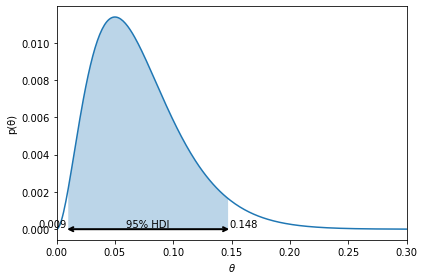

In [25]:
# 描画する
hm_thetas = hmv(thetas, ps, alpha=0.95)
plt.plot(thetas, ps)
plt.annotate('', xy=(hm_thetas.min(), 0),
             xytext=(hm_thetas.max(), 0),
             arrowprops=dict(color='black', shrinkA=0, shrinkB=0,
                             arrowstyle='<->', linewidth=2))
plt.annotate('{:.3f}'.format(hm_thetas.min()), xy=(hm_thetas.min(), 0),
             ha='right', va='bottom')
plt.annotate('{:.3f}'.format(hm_thetas.max()), xy=(hm_thetas.max(), 0),
             ha='left', va='bottom')
plt.annotate('95% HDI', xy=(hm_thetas.mean(), 0),
             ha='center', va='bottom')
hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
plt.xlabel(r'$\theta$')
plt.ylabel('p(θ)')
plt.xlim(0, 0.3)
plt.tight_layout()
plt.show()

デザインAのクリック率95%HDIはおよそ0.009~0.148の区間にあることがわかった。

In [26]:
def plot_hdi(ps, label):
    hm_thetas = hmv(thetas, ps, alpha=0.95)
    plt.plot(thetas, ps)
    plt.annotate('', xy=(hm_thetas.min(), 0),
                 xytext=(hm_thetas.max(), 0),
                 arrowprops=dict(color='black', shrinkA=0, shrinkB=0,
                                 arrowstyle='<->', linewidth=2))
    plt.annotate('{:.3f}'.format(hm_thetas.min()), xy=(hm_thetas.min(), 0),
                 ha='right', va='bottom')
    plt.annotate('{:.3f}'.format(hm_thetas.max()), xy=(hm_thetas.max(), 0),
                 ha='left', va='bottom')
    plt.annotate('95% HDI', xy=(hm_thetas.mean(), 0),
                 ha='center', va='bottom')
    hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
    plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
    plt.ylabel(label)
    plt.xlim(0, 0.3)
    plt.tight_layout()
    plt.yticks([])

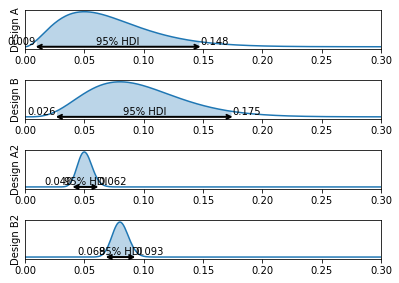

In [27]:
plt.subplot(4, 1, 1)
design_a = posterior(2, 40)
plot_hdi(design_a, 'Design A')

plt.subplot(4, 1, 2)
design_b = posterior(4, 50)
plot_hdi(design_b, 'Design B')

plt.subplot(4, 1, 3)
design_a2 = posterior(64, 1280)
plot_hdi(design_a2, 'Design A2')

plt.subplot(4, 1, 4)
design_b2 = posterior(128, 1600)
plot_hdi(design_b2, 'Design B2')

- サンプルを増やせば（2系。後半2つのサンプルサイズを増やしたバージョンをそう呼ぼう）裾が短く、HDIの範囲も縮小していることがわかる。
- その結果、2系はAとBにおいてHDIの重なる部分が少なくなっている。

この特徴をもとに以下のように仮説検証できる。
- 仮設
 - デザインBのクリック率は5%よりも大きい
- 考察
　- 95%HDIの最小値は5%より大きいため、仮設は正しそう。

(参考)  
**ROPE**(Region of paractical equivalence)：5%前後0.5%（つまり4.5~5.5）は5%と同じ、と考えるその範囲のこと。人間はあいまいなもので、有意水準を5%と決めたとしても、p値が0.055とかだとめちゃくちゃ気持ちが揺らぐものである。この揺らぎをどこまで許容するかをROPEで定義する。

- 仮設
 - デザインB案のクリック率はデザインA案より大きい。
- 考察
 - デザインB案のクリック率の95%HDIはデザインA案のクリック率の95%HDIの外にある時、2つのクリック率は異なる。特に前者の最小値が後者の最大値より大きければ前者の方が大きいと言える。2系ならその結論を下せるだろう。  

また、上記仮設に対して新しい確率変数を導入して考えることもできる。
$$
δ = θ_{ B } - θ_{ A }
$$
このδが正の値をとるかどうか見れば良いのである。

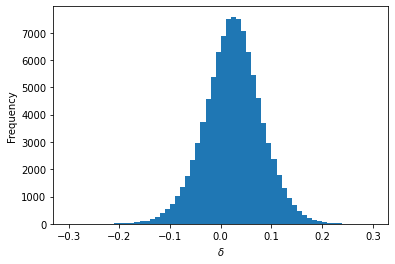

In [28]:
# デザインAとBの各々のベータ分布から100000個乱数を用意してδのヒストグラムを確認する
theta_a = np.random.beta(3, 39, size=100000)
theta_b = np.random.beta(5, 47, size=100000)
delta = theta_b - theta_a
plt.hist(delta, range=(-0.3, 0.3), bins=60)
plt.xlabel(r'$\delta$')
plt.ylabel('Frequency')
plt.show()

In [29]:
print((delta > 0).mean())

0.68127


ヒストグラム的には微妙に正の値に傾いているが、負の値を取ることも結構ありそうである。  
正の値をとる割合を出してみると68%と信念が弱い。

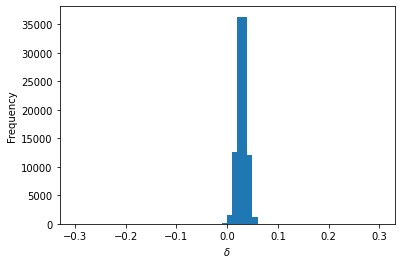

In [30]:
# デザインA2とB2の各々のベータ分布から100000個乱数を用意してδのヒストグラムを確認する
theta_a = np.random.beta(65, 1217, size=100000)
theta_b = np.random.beta(129, 1473, size=100000)
delta = theta_b - theta_a
plt.hist(delta, range=(-0.3, 0.3), bins=60)
plt.xlabel(r'$\delta$')
plt.ylabel('Frequency')
plt.show()

In [31]:
print((delta > 0).mean())

0.99937


サンプルを増やした2系で同じようにみると結果は一目瞭然となった。